## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Blog-Generator"

# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
# llm=ChatGroq(model="qwen-2.5-32b")

## Defining the tools

#### Arxiv

In [2]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

listed_articles = [] # global variables. This should be saved into a vector database

@traceable
def arxiv_search(query):
    """
        Search for the top 2 results according to the user query using ArxivAPIWrapper.
        The information returned is a list with the top 2 related articles with at least the following information:
        Title
        Published
        Authors
        Summary
        PDF_url
    """

    # Using qwen-2.5-32b limits to 6000 per minute so I set doc_content_chars_max = 5900
    arxiv = ArxivAPIWrapper(
        top_k_results = 2,
        ARXIV_MAX_QUERY_LENGTH = 300,
        load_all_available_meta = True,
        doc_content_chars_max = 500
    )

    # Run Query and Get Results
    # query = "GAN's"
    results = arxiv.load(query)

    for article in results:
        listed_articles.append(article.metadata.get('Title', 'N/A'))
        print(f"Title: {article.metadata.get('Title', 'N/A')}")
        print(f"Published: {article.metadata.get('Published', 'N/A')}")
        print(f"Authors: {article.metadata.get('Authors', 'N/A')}\n")
        print(f"Summary: {article.metadata.get('Summary', 'N/A')[:250]}\n")
        print(f"PDF url: {article.metadata.get('entry_id', 'N/A')}\n")
    return results


#### Wikipedia

In [3]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

## Binding the tools

In [4]:
tools=[wiki,arxiv_search]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=True)

## Define the Initial State

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [6]:
# System message
sys_msg = SystemMessage(content=
                        """You are a helpful assistant tasked with creating a blog.
                        Your first commitment is:
                        1. Use the arxiv tool to search for the top 2 articles related to the user's question.

                        2. Give the user the option to use wikipedia in case they want to research a term in the summaries.

                        3. Wait for user's feedback

                        4. If rejected try again from point 1.

                        5. If accepted create a blog with the articles information.
                     
                        """)                      


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Defining the graph

#### First I define a node that will be helpful for the human feedback

In [7]:
# def create_blog_entry(state: MessagesState):
#     """Indicates what arxiv articles should be selected to create a post."""

#     # Simulating user input (In real use, take input dynamically)
#     user_input = "Create a blog post about the second article"

#     # Append user input to state
#     new_message = HumanMessage(content=user_input)

#     # Return the updated state with all messages
#     return {"messages": state["messages"] + [new_message]}

In [8]:
def create_blog_entry(state: MessagesState):
    """This function is called when the user has accepted the blog post creation.
    It will be created manually durin execution"""
    pass

In [9]:
from langgraph.graph import START, StateGraph, END

@traceable
def human_feedback(state: MessagesState):
    """ Return the next node to execute """
    
    user_input = state["messages"][-1].content.lower()
    if "yes" in user_input:
        return "tools"
    elif "no" in user_input or "end" in user_input:
        return create_blog_entry 
    return create_blog_entry


In [10]:
@traceable
def custom_condition(state: MessagesState):
    """ Manually decide whether to go to tools or end. """
    decision = human_feedback(state)  # Use the updated function

    if decision == "tools":
        return "tools"
    return "create_blog_entry"  

#### Then I define the graph

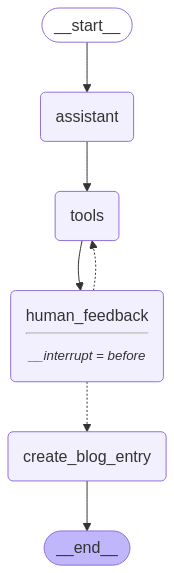

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("human_feedback",human_feedback)
builder.add_node("tools",ToolNode(tools))
builder.add_node("create_blog_entry",create_blog_entry)
# Define edges
builder.add_edge(START,"assistant")
builder.add_edge("assistant","tools")
builder.add_edge("tools","human_feedback")
builder.add_conditional_edges(
    "human_feedback", custom_condition, {"tools": "tools", "create_blog_entry": "create_blog_entry"}
)
builder.add_edge("create_blog_entry",END)   

# Set up memory
memory = MemorySaver()
# Compile the graph with memory
scienceBlogCreator = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

# Show
display(Image(scienceBlogCreator.get_graph().draw_mermaid_png()))

## Using the Agent

#### First call to use the Arxiv tool

#### Invoking the llm

In [12]:
# Input
# user_input=input("What do you want to research about?")
user_input="GANs"
messages = {"messages": HumanMessage(content=user_input)}

thread={"configurable":{"thread_id":"arxiv_call_1"}}

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_lQCI1yJ2qxRi5N9e18mv1qMl)
 Call ID: call_lQCI1yJ2qxRi5N9e18mv1qMl
  Args:
    query: GANs
Title: Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey
Published: 2021-11-26
Authors: Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley

Summary: This is a tutorial and survey paper on Generative Adversarial Network (GAN),
adversarial autoencoders, and their variants. We start with explaining
adversarial learning and the vanilla GAN. Then, we explain the conditional GAN
and DCGAN. The mode col

PDF url: http://arxiv.org/abs/2111.13282v1

Title: GAN You Do the GAN GAN?
Published: 2019-04-01
Authors: Joseph Suarez

Summary: Generative Adversarial Networks (GANs) have become a dominant class of
generative models. In recent years, GAN variants have yielded especi

In [13]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_lQCI1yJ2qxRi5N9e18mv1qMl)
 Call ID: call_lQCI1yJ2qxRi5N9e18mv1qMl
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [14]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [15]:
scienceBlogCreator.get_state(thread).tasks

(PregelTask(id='ce729d1e-4b0d-1116-8283-9a9f265580bf', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),)

## Human Feedback

#### Update the state asking to the user if they want to research a topic in wikipedia

In [16]:
# user_input=input("Do you want to clarify any term by using Wikipedia?")
user_input="yes, research what is a network in machine learning using wikipedia"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        HumanMessage(content=user_input)
    ]},
    #  as_node="human_feedback"
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

yes, research what is a network in machine learning using wikipedia
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_0iiVLvMuy0JmZCNyaHkMtOCr)
 Call ID: call_0iiVLvMuy0JmZCNyaHkMtOCr
  Args:
    query: network in machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks wit


In [17]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_lQCI1yJ2qxRi5N9e18mv1qMl)
 Call ID: call_lQCI1yJ2qxRi5N9e18mv1qMl
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [18]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [19]:
# Input
# user_input=input("Do you want to research another term in wiki?")
user_input="yes, research who created the adversarial architecture"
scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        # HumanMessage(content=f'{{"arguments": {{"query": "{user_input}"}}}}')
        HumanMessage(content=user_input)
    ]}
)

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

yes, research who created the adversarial architecture
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9pQrYomP3MI7vaBMTfqjkbmz)
 Call ID: call_9pQrYomP3MI7vaBMTfqjkbmz
  Args:
    query: adversarial architecture
================================= Tool Message =================================
Name: wikipedia

Page: Generative adversarial network
Summary: A generative adversarial network (GAN) is a class of machine learning frameworks and a prominent framework for approaching generative artificial intelligence. The concept was initially developed by Ian Go


In [20]:
scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [21]:
new_state = scienceBlogCreator.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

GANs
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_lQCI1yJ2qxRi5N9e18mv1qMl)
 Call ID: call_lQCI1yJ2qxRi5N9e18mv1qMl
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWassers

In [22]:
# user_input=input("Do you want to research another term in wiki?")
user_input = "No, I do not want to research another term in wiki"

scienceBlogCreator.update_state(
    thread,
    {"messages": [
        SystemMessage(content="""Based on the next user answer, decide if you should return to the tools 
                      node to make a wikipedia search or if you should proceed to create  the blog entry."""),
        # HumanMessage(content=f'{{"arguments": {{"query": "{user_input}"}}}}')
        HumanMessage(content=user_input)
    ]}
)

decision = human_feedback(scienceBlogCreator.get_state(thread).values)
print(f"Decision: {decision}")

scienceBlogCreator.get_state(thread).next
# Stream execution
# for event in scienceBlogCreator.stream(messages, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()

Decision: <function create_blog_entry at 0x00000230986619E0>


('human_feedback',)

## Creating the Blog entry

In [23]:
# Simulating user input (In real use, take input dynamically)
user_input = "Create a blog post about the second article"

scienceBlogCreator.update_state(
        thread,
        {"messages": [            
            # HumanMessage(content=user_input),
            SystemMessage(content=f"""The arxiv articles are ordered here: {listed_articles}.
                          Pick the appropriate article in the list according to the number requested by the user
                          here {user_input}.
                          For instance, if the user wants to create a blog post about the first article,
                          then you should create a blog post about {listed_articles[0]}.
                          If the user wants to create a blog post about the second article,
                          then you should create a blog post about {listed_articles[1]}, and so on                       
                          It should be an engaging post of at most 200 words.
                          The title of the post should be the title of the article.
                          """)
        ]}, as_node="create_blog_entry"
    )

for event in scienceBlogCreator.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ System Message ================================

The arxiv articles are ordered here: ['Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'GAN You Do the GAN GAN?'].
                          Pick the appropriate article in the list according to the number requested by the user
                          here Create a blog post about the second article.
                          For instance, if the user wants to create a blog post about the first article,
                          then you should create a blog post about Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey.
                          If the user wants to create a blog post about the second article,
                          then you should create a blog post about GAN You Do the GAN GAN?, and so on                       
                          It should be an engaging post of at most 200 words.
                          Th

In [ ]:
# scienceBlogCreator.get_state(thread).next

('human_feedback',)

In [ ]:
# scienceBlogCreator.get_state(thread).values

{'messages': [HumanMessage(content='GANs', additional_kwargs={}, response_metadata={}, id='d06eaef6-4e47-4e0a-a893-bba6b2778391'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lQCI1yJ2qxRi5N9e18mv1qMl', 'function': {'arguments': '{"query":"GANs"}', 'name': 'arxiv_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 263, 'total_tokens': 280, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6e5e97b2-66e1-4c7c-a092-1e8c61301b3b-0', tool_calls=[{'name': 'arxiv_search', 'args': {'query': 'GANs'}, 'id': 'call_lQCI1yJ2qxRi5N9e18mv1qMl', 'type': 'tool_call'}], usage_metadata={'input_tokens': 263, 'output_to

In [26]:
# # Continue the graph execution
# for event in scienceBlogCreator.stream(None, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()


In [30]:
state_after_feedback = scienceBlogCreator.get_state(thread).values
decision = tools_condition(state_after_feedback)
print(f"🛠️ tools_condition decision: {decision}")


🛠️ tools_condition decision: __end__
